# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [46]:
import sys
!{sys.executable} -m pip install xgboost

In [24]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBRegressor 
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.pipeline import Pipeline
import traceback
from sklearn.preprocessing import StandardScaler

import pickle
from sklearn.externals import joblib

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [6]:
azdias_copy = azdias.copy(deep=True)

In [7]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('number of rows and columns - gen. demo. data:',azdias.shape)
print('number of rows and columns - customers of mail order company:',customers.shape)

number of rows and columns - gen. demo. data: (891221, 366)
number of rows and columns - customers of mail order company: (191652, 366)


In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [2]:
info_attributes = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')
attributes_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')

# Reusing the Feature info provided for the other project
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [153]:
attributes_values.head(6)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


In [154]:
attr_notna = attributes_values['Attribute'].fillna(method='ffill')
print('Total attributes in DIAS Attributes - Values: ',len(attr_notna))

attributes_values['Attribute'] = attr_notna

Total attributes in DIAS Attributes - Values:  2258


In [155]:
# filtering for the unknowns i.e. 'unknown' or 'no '

attributes_values = attributes_values[(attributes_values['Meaning'].str.contains("unknown") | 
                                       attributes_values['Meaning'].str.contains("no "))]

In [156]:
ls = []
for attr in attributes_values['Attribute'].unique():
    ele = attributes_values.loc[attributes_values['Attribute'] == attr, 'Value'].astype(str).str.cat(sep=',').split(',')
    ls.append(ele)
    
attr_comb = pd.concat([pd.Series(attributes_values['Attribute'].unique()), pd.Series(ls)], axis=1)
attr_comb.columns = ['Attribute', 'Value']
attr_comb.head(5)

,Attribute,Value
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [157]:
# Get the list of non nan Attributes

attr_notna = attributes_values[attributes_values['Attribute'].notna()]
print('Total attributes in DIAS Attributes - Values: ',len(attr_notna))

print('Total attributes in DIAS info file:',len(set(info_attributes['Attribute'])))

# List of Attributes with given unknowns
print('Unknown values in DIAS Attributes - Values: ',len(set(attr_comb['Attribute'])))

Total attributes in DIAS Attributes - Values:  302
Total attributes in DIAS info file: 313
Unknown values in DIAS Attributes - Values:  292


### Step 0.1: Combine both old and new features info files with unknowns  
- and then remove the duplicate entries
- and also remove the columns from info files which are not in azdias.



In [158]:
# combining missing values from old and new files.

new_attr = list(attr_comb['Attribute'])
new_vals = list(attr_comb['Value'])

n_val = []
for i in new_vals:
    string = str(i).replace("'", "") 
    n_val.append(string)

old_attr = list(feat_info['attribute'])
old_vals = list(feat_info['missing_or_unknown'])

comb_attr = old_attr + new_attr
comb_vals = old_vals + n_val

combined_feat_info = pd.DataFrame(list(zip(comb_attr, comb_vals)),columns=['Attributes', 'Missing'])

In [159]:
# Remove duplicates in combined unknowns 

duplicate_attr = combined_feat_info.duplicated(subset=['Attributes'])

# Print duplicates
# if duplicate_attr.any():
#     print(combined_feat_info.loc[duplicate_attr], end='\n\n')

# drop duplicates in Attributes
combined_feat_info.drop_duplicates(subset ="Attributes",inplace=True)
combined_feat_info.shape

(317, 2)

In [160]:
# With the assumption that the features with D_19 prefix belong to the same category
#Replacing e.g. D19_BIO_OEKO_RZ with D19_BIO_OEKO --> removing _RZ
import re

info_attributes['Attribute'] = info_attributes['Attribute'].apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)
combined_feat_info['Attributes'] = combined_feat_info['Attributes'].apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)

In [161]:
# Remove columns from combined unknowns  which are not in azdias

not_in_azdias =  list(set(combined_feat_info['Attributes']) - set(azdias.columns))
print(len(not_in_azdias), not_in_azdias)

# Remove attributes
for i in not_in_azdias:
    combined_feat_info = combined_feat_info[combined_feat_info.Attributes != i]

9 ['BIP_FLAG', 'WACHSTUMSGEBIET_NB', 'D19_BUCH', 'CAMEO_DEUINTL_2015', 'SOHO_FLAG', 'HAUSHALTSSTRUKTUR', 'D19_KK_KUNDENTYP', 'KBA13_CCM_1400_2500', 'GEOSCORE_KLS7']


In [162]:
not_in_attr =  set(attr_notna['Attribute']) - set(azdias.columns)

print('Azdias attributes which are not in DIAS Attributes - Values:', len(not_in_attr))
print(len(set(attr_notna['Attribute'])), len(set(azdias.columns)))

Azdias attributes which are not in DIAS Attributes - Values: 42
292 366


In [163]:
not_in_az_infos = list(set(info_attributes['Attribute']) - set(azdias.columns))

print('Attributes not in DIAS Info file:', len(not_in_az_infos), not_in_az_infos)

Attributes not in DIAS Info file: 17 ['WACHSTUMSGEBIET_NB', 'PLZ8', 'PLZ', 'GKZ', 'CAMEO_DEUINTL_2015', 'SOHO_FLAG', 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24', 'D19_BUCH', 'HAUSHALTSSTRUKTUR', 'D19_KK_KUNDENTYP', 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24', 'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24', 'KBA13_CCM_1400_2500', 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24', 'EINWOHNER', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24', 'GEOSCORE_KLS7']


In [164]:
# Removing info attributes which are not in azdias

for i in not_in_az_infos:
    info_attributes = info_attributes[info_attributes.Attribute != i]

In [165]:
attr_not_in_infos = list(set(combined_feat_info['Attributes']) - set(info_attributes['Attribute']))
print('Attributes not in DIAS Info file:', len(attr_not_in_infos), attr_not_in_infos)

Attributes not in DIAS Info file: 16 ['D19_VERSI_ANZ_24', 'KK_KUNDENTYP', 'KBA13_CCM_3001', 'D19_BANKEN_ANZ_12', 'D19_VERSI_ANZ_12', 'D19_GESAMT_ANZ_12', 'KBA13_CCM_3000', 'D19_LOTTO', 'SOHO_KZ', 'D19_GESAMT_ANZ_24', 'D19_BANKEN_ANZ_24', 'D19_TELKO_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_TELKO_ANZ_24', 'CAMEO_INTL_2015']


In [166]:
info_attributes.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [167]:
print('Finally, {} combined unique features are encoded as missing values'.format(combined_feat_info['Attributes'].nunique()))

Finally, 308 combined unique features are encoded as missing values


In [26]:
# List 

no_info_feats =  set(azdias.columns) - set(info_attributes['Attribute'])
print(len(no_info_feats), no_info_feats)

70 {'D19_BANKEN_ANZ_12', 'D19_TELKO_ONLINE_QUOTE_12', 'UNGLEICHENN_FLAG', 'VK_DISTANZ', 'HH_DELTA_FLAG', 'D19_VERSI_ANZ_12', 'VHA', 'KBA13_CCM_1401_2500', 'CJT_TYP_6', 'MOBI_RASTER', 'RT_SCHNAEPPCHEN', 'VK_ZG11', 'CJT_TYP_2', 'AKT_DAT_KL', 'EXTSEL992', 'UMFELD_JUNG', 'RT_UEBERGROESSE', 'ALTERSKATEGORIE_FEIN', 'D19_LOTTO', 'STRUKTURTYP', 'D19_SOZIALES', 'VHN', 'LNR', 'VERDICHTUNGSRAUM', 'KBA13_GBZ', 'KONSUMZELLE', 'KBA13_BAUMAX', 'EINGEFUEGT_AM', 'GEMEINDETYP', 'ANZ_KINDER', 'KBA13_ANTG3', 'D19_KONSUMTYP_MAX', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND4', 'D19_BUCH_CD', 'KBA13_HHZ', 'RT_KEIN_ANREIZ', 'VK_DHT4A', 'CJT_TYP_5', 'KK_KUNDENTYP', 'ALTER_KIND1', 'CAMEO_INTL_2015', 'D19_VERSI_ANZ_24', 'D19_VERSAND_ANZ_12', 'KBA13_ANTG4', 'KBA13_ANTG1', 'D19_BANKEN_ANZ_24', 'CJT_TYP_3', 'KBA13_CCM_3001', 'D19_TELKO_ANZ_12', 'FIRMENDICHTE', 'DSL_FLAG', 'EINGEZOGENAM_HH_JAHR', 'D19_GESAMT_ANZ_24', 'ALTER_KIND3', 'KOMBIALTER', 'CJT_TYP_1', 'ANZ_STATISTISCHE_HAUSHALTE', 'SOHO_KZ', 'CJT_TYP_4', 'D19_TE

In [168]:
# Remove '[]' and split with ',' and filter based on data types, 2nd check for empty, and then 
# check for [-1.0, 'X'], ['XX'], [-1.0, 'XX']

import string

def format_unknowns(attr, missings, azdias):
    
    type_is =[]
    for data in attr.tolist():
        try:
            type_is.append(azdias[data].dtypes)
        except:
            print('not in azdias', data)

    nan_list = []   # to get the nan check for each attribute
    unk_list = []   # to save all nan checks for all attributes respectively
    etc_list = []   # to save -1, X etc.
    type_index = 0

    for chks in missings:

        chks = str(chks)
        chks = chks.replace('[','').replace(']','').split(',')

        nan_list = chks

        try:
            if type_is[type_index] == 'int64':
                nan_list = list(map(int, nan_list)) 
                unk_list.append(nan_list)

            elif type_is[type_index] == 'float64':
                nan_list = list(map(float, nan_list)) 
                unk_list.append(nan_list)

            elif type_is[type_index] == 'O':

                if nan_list == ['XX']:
                    unk_list.append(['XX'])

                elif nan_list == ['-1']:
                    unk_list.append(['-1'])

                elif '-1' and 'XX' in nan_list:
                    etc_list = [-1.0, 'XX']
                    unk_list.append(etc_list)

                elif '-1' and 'X' in nan_list:
                    etc_list = [-1.0, 'X']
                    unk_list.append(etc_list)
            else:
                print('fix it!', type_is[type_index], nan_list)

        except:
            try:
                if nan_list == ['']:
                    unk_list.append(['nan'])

                else:
                    ('Its something new', nan_list)               

            except:
                print('exception')
                unk_list.append('exception')

        type_index +=1

    print(len(unk_list))
    print(unk_list)
    
    return unk_list

In [169]:
# get the formatted unknowns

missings = combined_feat_info['Missing']
attr = combined_feat_info['Attributes']

# Formatting the unknowns
unk_list = format_unknowns(attr, missings, azdias)

combined_feat_info['Missing'] = pd.Series(unk_list)

308
[[-1, 0], [-1, 0, 9], [-1, 0], [0.0], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [0], ['nan'], ['nan'], [-1, 0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [-1, 0], [-1, 0], [0.0], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1], [-1.0], [-1.0, 0.0], [-1], [-1, 9], [0.0], ['nan'], ['nan'], [-1.0, 0.0], [-1.0], [-1.0, 0.0], [-1.0, 0.0], [0.0], ['nan'], [-1.0, 0.0], ['nan'], [0.0], ['-1'], [-1.0], [-1.0, 'X'], ['XX'], [-1.0, 'XX'], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0, 0.0], [-1.0, 0.0], [-1.0], [-1.0], [-1.0], ['nan'], [-1.0, 0.0], ['nan'], ['nan'], [-1.0, 0.0], ['nan'], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0, 0.0], [-1.0], [-1.0], [-1.0, 9.0], [-1.0, 0.0], [-1.0, 9.0], [0], [0], [10], [0], [0], [0], [10], [10], [0.0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [10], [10], [10], [0.0], [0], [0], [0], [0], [0], [0.0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [10], [0], [10], [10], [0

In [170]:
#print(combined_feat_info['Missing'])
combined_feat_info.shape

(308, 2)

In [171]:
# drop the nans in the combined features

combined_feat_info = combined_feat_info[combined_feat_info['Missing'].notna()]
print(combined_feat_info.shape)

# save it for later time saving
combined_feat_info.to_pickle('data/combined_feat_info_copy.pkl')

(276, 2)


In [179]:
azdias_copy = azdias.copy(deep=True)
#customers_copy = customers.copy(deep=True)
#c_good = replace_nans(customers_copy, feat_info_pickle)
#a_good, anans_all_after, arate = replace_nans(azdias_copy, feat_info_pickle)

In [4]:
# replace with nans

def replace_nans(df, combined_feat_info):
    u_index = 0
    
    missings = list(combined_feat_info['Missing'])
    attr = combined_feat_info['Attributes']

    for x in attr:

        try:        
            if ['nan'] != missings[u_index]:

                for i in missings[u_index]:
                    df[x] = df[x].replace({i:np.nan})
        except:
            print(x, missings[u_index])

        u_index +=1
            
    return df

#azdias_good = replace_nans(azdias_copy, combined_feat_info)

In [181]:
nans_all_after = []
rate = []
for z in azdias_good:
    tot = azdias_good[z].isna().sum()
    nans_all_after.append(tot)
    rate.append((tot/azdias_good.shape[0])*100)   
    
#tot_points = azdias.shape[0]*azdias.shape[1]
print('After replacement:',len(nans_all_after), nans_all_after) 

After replacement: 366 [0, 685843, 73499, 310267, 810163, 861722, 885051, 890016, 262947, 99611, 97008, 73499, 73499, 93148, 73499, 97375, 93740, 99352, 99352, 99352, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 831734, 794100, 0, 728811, 785351, 874745, 0, 0, 845987, 821760, 809304, 692502, 0, 0, 0, 857661, 761014, 829857, 790748, 851626, 584797, 505303, 0, 0, 0, 650188, 768381, 713100, 749365, 257113, 0, 745836, 0, 257113, 747956, 0, 0, 736924, 802085, 773024, 505953, 257113, 0, 0, 0, 0, 726804, 0, 0, 257113, 765973, 852220, 637972, 0, 100846, 124063, 82541, 261044, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 93148, 93148, 73499, 93740, 654153, 0, 0, 0, 0, 0, 0, 0, 93155, 93148, 93155, 392318, 97274, 4854, 0, 111196, 107602, 18348, 93740, 148110, 148110, 148110, 148110, 147201, 133324, 133324, 133324, 133324, 148115, 476524, 148110, 148110, 148110, 148110, 148110, 148110, 133324, 148110, 148110, 148110, 148110, 148110, 110037, 148110, 148110, 148110, 148110, 148110, 148110, 148110, 148110,

In [37]:
nan_alls_before = []
for z in azdias:
    nan_alls_before.append(azdias[z].isna().sum())
    
#tot_points = azdias.shape[0]*azdias.shape[1]
print('Before replacement:',len(nan_alls_before), nan_alls_before) 

Before replacement: 366 [0, 0, 73499, 73499, 810163, 861722, 885051, 890016, 262947, 93148, 97008, 73499, 73499, 93148, 73499, 97216, 93740, 98979, 98979, 98979, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 0, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 257113, 0, 0, 0, 257113, 257113, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 93148, 93148, 73499, 93740, 654153, 0, 0, 0, 0, 0, 0, 0, 93155, 93148, 93155, 0, 97274, 4854, 0, 0, 107602, 18348, 93740, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 93148, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 93148, 133324, 133324, 133324, 133324, 133324, 133324, 13332

In [38]:
tot_points = azdias.shape[0]*azdias.shape[1]
print('Before replacement:')#,len(nan_alls), nan_alls)
print( 'sum is:', sum(nan_alls_before), 'percenatge is:', (sum(nan_alls_before)/tot_points)*100 )

print('After replacement:')#,len(nans_all_after), nans_all_after) 
print( 'sum is:', sum(nans_all_after), 'percenatge is:', (sum(nans_all_after)/tot_points)*100 )
#print( 'sum is:', sum(nan_alls_after), 'percenatge is:', (sum(nan_alls_after)/tot_points)*100 )

Before replacement:
sum is: 33492923 percenatge is: 10.2680164156
After replacement:
sum is: 59466344 percenatge is: 18.23075867


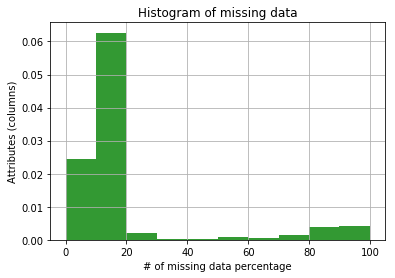

In [39]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

x = rate

# the histogram of the data
n, bins, patches = plt.hist(x, density=True, facecolor='g', alpha=0.8)

plt.xlabel('# of missing data percentage')
plt.ylabel('Attributes (columns)')
plt.title('Histogram of missing data')
plt.grid(True)
plt.show()

In [40]:
c_ind_above = np.argwhere(np.asarray(nans_all_after) > 200000)
c_ind_above = list(map(int, c_ind_above))
print('column indices to drop: ',c_ind_above, len(c_ind_above))
print(list(azdias_copy.iloc[:0, c_ind_above]))

column indices to drop:  [1, 3, 4, 5, 6, 7, 8, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 57, 59, 61, 62, 65, 66, 67, 68, 69, 74, 77, 78, 79, 80, 85, 92, 100, 111, 129, 300, 349] 48
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 

In [41]:
# Tested for customers

c_ind_above = np.argwhere(np.asarray(rate) > 30)
c_ind_above = list(map(int, c_ind_above))
print('column indices to drop: ',c_ind_above, len(c_ind_above))
print(list(azdias_copy.iloc[:0, c_ind_above]))

column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 349] 41
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


#### Dicussion - Dropped Columns:  
As observed from the histogram, there are many columns(see mentioned above) with >200000 NaNs in the columns therefore they were removed from the azdias.

In [184]:
# Drop the columns from azdias

azdias_copy.drop(azdias_copy.columns[c_ind_above], axis=1, inplace=True)
#azdias_copy.shape

In [71]:
# Drop the columns from combined feat_infos as well

# combined_feat_info_copy = combined_feat_info.copy(deep=True)
# combined_feat_info_copy.drop(combined_feat_info_copy.columns[c_ind_above], axis=1, inplace=True)
# combined_feat_info_copy.shape

In [43]:
# How much data is missing in each row of the dataset?

rows_n = []
for i in range(len(azdias_copy.index)) :
    rows_n.append(azdias_copy.iloc[i].isnull().sum())
    if i % 150000 == 0:
        print("Nan in row ", i , " : " ,  rows_n[i])
        
print(rows_n[:10])
print(len(rows_n))

Nan in row  0  :  245
Nan in row  150000  :  1
Nan in row  300000  :  3
Nan in row  450000  :  6
Nan in row  600000  :  0
Nan in row  750000  :  12
[245, 6, 0, 8, 1, 0, 1, 0, 6, 0]
891221


891221 2


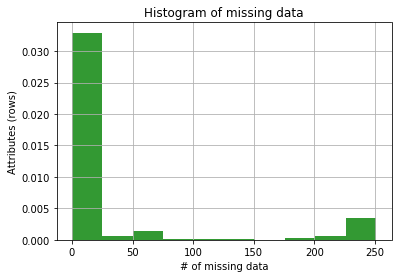

In [44]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
print(len(rows_n), rows_n[880000])
y = rows_n

# the histogram of the data
n, bins, patches = plt.hist(y, density=True, facecolor='g', alpha=0.8)

plt.xlabel('# of missing data')
plt.ylabel('Attributes (rows)')
plt.title('Histogram of missing data')
plt.grid(True)
plt.show()

In [46]:

# # Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 25 # interpreted from the histogram

r_ind_above = np.argwhere(np.asarray(rows_n) > threshold)
r_ind_above = list(map(int, r_ind_above))
print(r_ind_above[:10], len(r_ind_above))

r_ind_below = list(np.argwhere(np.asarray(rows_n) < threshold))
r_ind_below = list(map(int, r_ind_below))
print(r_ind_below[:10], len(r_ind_below))

[0, 11, 12, 13, 14, 15, 17, 20, 23, 24] 154916
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 736046


In [178]:
azdias_bad = azdias_copy.iloc[[0, 11, 12, 13, 14, 15, 17, 20, 23, 24] ,:]
#azdias_good = azdias_copy.iloc[r_ind_below ,:]

print(azdias_good.shape)
print(azdias_bad.shape)

(891221, 325)
(10, 325)


In [48]:
azdias_bad = azdias_copy.iloc[r_ind_above ,:]
azdias_good = azdias_copy.iloc[r_ind_below ,:]

print(azdias_good.shape)
print(azdias_bad.shape)

(736046, 325)
(154916, 325)


#### Dicussion - Dropped Rows:  
As observed from the histogram, there are many rows with NaNs with a threshold of 25 therefore they were removed from the azdias as well.

In [24]:
#azdias_good.to_pickle('data/azdias_good.pkl')
#combined_feat_info_copy.to_pickle('data/combined_feat_info_copy.pkl')

#customers.to_pickle('data/customers.pkl')
#azdias_pickle = pd.read_pickle('data/azdias_good.pkl')
feat_info_pickle = pd.read_pickle('data/combined_feat_info_copy.pkl')

In [176]:
import random
randoms = []
rand = 0
for x in range(7):
    rand = random.randint(0, 324)
    print(rand)
    if len(randoms) != 5:
        randoms.append(azdias_good.columns[rand])
print(randoms)

28
185
227
219
235
274
167
['D19_GESAMT_DATUM', 'KBA13_HALTER_35', 'KBA13_KW_80', 'KBA13_KW_120', 'KBA13_RENAULT']


In [1]:
# Optional: Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def columns_comparison(azdias_good, azdias_bad, randoms):
    for i in randoms:
        fig, axis = plt.subplots(figsize = (13,2), nrows=1, ncols=2)
        sns.countplot(azdias_good[i], ax = axis[0])
        sns.countplot(azdias_bad[i], ax = axis[1])
        axis[0].set_title('azdias_good < Threshold = 25')
        axis[1].set_title('azdias_bad > Threshold = 25')
    plt.show()

#columns_comparison(azdias_good, azdias_bad, randoms)


### Step 0.2: Select, Re-Encode and Re-Engineer Features  
- Special handling is necessary for the variable types: categorical and mixed.
- Decision to be made on whether to keep, drop, or re-encode each. Then, in the last part, a new data frame with only the selected and engineered columns will be created.
- Binary data is kept whereas the non numeric two state data is replaced by numeric binary data. For multi-level data, get_dummies is used.



In [6]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def categoricals_check(azdias_pickle, feat_info):    
    multi_level = []
    binary = []
    reencoded = []

    categoricals = feat_info[feat_info['type'].str.contains('categorical')]

    for i in categoricals.attribute:

        try:
            if len(azdias_pickle[i].value_counts()) == 2:
                try:
                    if float(str(azdias_pickle[i].value_counts())[0]):
                        binary.append(i)
                    else:
                        binary.append(i)
                except:
                    reencoded.append(i)
                    print('non-numeric binary - needs re-encoding:\n',azdias_pickle[i].value_counts())


            elif len(azdias_pickle[i].value_counts()) > 2:
                multi_level.append(i)
        except:
            print('key probably already removed from azdias:', i)

    print('Binary:      ', binary, len(binary))
    print('Multi_level: ', multi_level, len(multi_level))
    print('Reencoded:   ', reencoded, len(reencoded))
    
    return binary, multi_level, reencoded

#binary, multi_level, reencoded = categoricals_check(azdias_pickle, feat_info)

In [7]:
# reencode and engineering...
# fix OST_WEST_KZ

def binary_numeric(df_good):
    
    binary_numeric = []

    for k in df_good['OST_WEST_KZ']:
        if k == 'W':
            binary_numeric.append(0)
        else:
            binary_numeric.append(1)
    
    df_good.drop(['OST_WEST_KZ'],axis=1)
    df_good['OST_WEST_KZ'] = binary_numeric
    
    print('OST_WEST_KZ fixed')
    return df_good

#df_good = binary_numeric(azdias_pickle)

In [8]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def praegende_fix(azdias_good):

    avant = [2, 4, 6, 7, 9, 11, 13, 15]
    decade = []
    movement = []

    for i in azdias_good['PRAEGENDE_JUGENDJAHRE']:
        if i in avant:
            movement.append(0)
        else:
            movement.append(1)

    # for decade: 1-2,3-4,5-7,8-9,10-13, 14-15

    for j in azdias_good['PRAEGENDE_JUGENDJAHRE']:
        if j in [1,2]:
            decade.append(0)
        elif j in [3,4]:
            decade.append(1)
        elif j in range(5, 8):
            decade.append(2)
        elif j in [8,9]:
            decade.append(3)
        elif j in range(10, 14):
            decade.append(4)
        elif j in [14,15]:
            decade.append(5)
        else:
            decade.append(np.nan)
    
    azdias_good['PRAEGENDE_JUGENDJAHRE_D'] = decade
    azdias_good['PRAEGENDE_JUGENDJAHRE_M'] = movement
    
    #azdias_good.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    print('PRAEGENDE_JUGENDJAHRE can be deleted')

    return azdias_good

#azdias_good = praegende_fix(df_good)        

In [9]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def cameo_fix(azdias_good):
    wealth = []
    life = []

    for i in azdias_good['CAMEO_INTL_2015']:
        if i is not np.nan:
            wealth.append(str(i)[0])
            life.append(str(i)[1])
        else:
            wealth.append(np.nan)
            life.append(np.nan)

    azdias_good['CAMEO_INTL_2015_W'] = wealth
    azdias_good['CAMEO_INTL_2015_L'] = life
    
    #azdias_good.drop('CAMEO_INTL_2015',axis=1)
    
    print('CAMEO_INTL_2015 can be deleted')
    
    return azdias_good

#azdias_good = cameo_fix(azdias_good)

In [10]:
def wohnlage_fix(df_good):
    
    new = []
    rural = [7,8]
    neigh = [1,2,3,4,5]

    for k in df_good['WOHNLAGE']:
        if k in neigh:
            new.append(0)
        elif k in rural:
            new.append(1)
        else:
            new.append(np.nan)
    
    #df_good.drop(['WOHNLAGE'],axis=1)
    df_good['NEIGHBOUR_RURAL'] = new
    
    print('WOHNLAGE can be deleted')
    return df_good

#azdias_good = wohnlage_fix(azdias_good)
#azdias_good['NEIGHBOUR_RURAL'].value_counts()

In [11]:
def baumax_fix(df_good):
    
    family = []
    business = []

    for k in df_good['PLZ8_BAUMAX']:
        if k == 5:
            business.append(1)
            family.append(np.nan)
        elif k > 0 and k < 5:
            family.append(k)
            business.append(0)
        else:
            family.append(np.nan)
            business.append(np.nan)
    
    df_good['PLZ8_BAUMAX_Family'] = family
    df_good['PLZ8_BAUMAX_Business'] = business
    
    print('PLZ8_BAUMAX can be deleted')
    return df_good

#azdias_good = baumax_fix(azdias_good)

In [12]:
def eingefugt_fix(df_good):
    
    eingefugt = []
    for i in df_good['EINGEFUEGT_AM']:
        if i is not np.nan:
            x = str(i)[:4]
            eingefugt.append(int(x))
        else:
            eingefugt.append(np.nan)
            
    df_good['EINGEFUEGT_AM_New'] = pd.Series(eingefugt)
    
    print('EINGEFUEGT_AM is fixed')
    return df_good

#azdias_good = eingefugt_fix(azdias_good)
#azdias_good['EINGEFUEGT_AM_New'].value_counts()

In [13]:
# Engineer and reencode
def engineer_reencode(df, mls, feat_info):
    
    df = binary_numeric(df)
    df = praegende_fix(df)
    df = cameo_fix(df)
    df = wohnlage_fix(df)
    df = baumax_fix(df)
    df = eingefugt_fix(df)
    
    for_dummies, for_delete = filter_multis(df, mls)
    df = drop_extra_cols(df, for_delete, feat_info)
    
    return df, for_dummies
#df , for_dummies = engineer_reencode(df, multi_level)

In [14]:
# filtering the multi_levels for get_dummies to to_delete

def filter_multis(df, multi_level):
    for_delete = []
    for_dummies = []
    for i in multi_level:
        try:
            s = df[i].value_counts()
            #print(s)

            if len(s) < 10:
                for_dummies.append(i)
            else:
                for_delete.append(i)
        except:
            print(i, 'key already dropped!')
            
    print('For get_dummies:    ',for_dummies, len(for_dummies))        
    print('To delete:          ', for_delete, len(for_delete))   
    
    return for_dummies, for_delete

In [15]:
# Delete all un necessary features

def drop_extra_cols(df, deletes, feat_info):
    
    mixed = feat_info[feat_info['type'].str.contains('mixed')]
    to_delete = ['VERDICHTUNGSRAUM', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM']

    to_delete = to_delete + list(mixed.attribute) + list(deletes)
    print('Columns to delete: ',to_delete)

    for i in list(to_delete):
        try:
            #print(i)
            df.drop(i,axis=1,inplace=True)
        except:
            print(i, 'already deleted in the previous steps')
    
    return df

### Summary: Select and Re-Encode Features  
- OST_WEST_KZ reencoded with 'W' = 0, else 1
- PRAEGENDE_JUGENDJAHRE_D and PRAEGENDE_JUGENDJAHRE_M created from PRAEGENDE_JUGENDJAHRE based on 'decade' and 'movement' info.
- NEIGHBOUR_RURAL is created from WOHNLAGE based on rural and neighbourhood info.
- CAMEO_INTL_2015_W and CAMEO_INTL_2015_L created from CAMEO_INTL_2015 based on wealth and life info.
- PLZ8_BAUMAX_Family and PLZ8_BAUMAX_Business created from PLZ8_BAUMAX based on the info family and business info.
- Remaining 'mixed' types are removed from the dataset because of many 0s - also the orignal features were removed as the encoded and engineered feature were added.
- VERDICHTUNGSRAUM, ANZ_KINDER, CAMEO_DEU_2015 also removed because of so many multi levels.
- ANZ_TITEL, ANZ_HH_TITEL dropped because of many 0s.
- LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB dropped because of complex data.


In [20]:
#azdias_good['KBA05_BAUMAX'].value_counts()

In [16]:
# get dummy variables for multi_level features
def make_dummies(df, d):
    
    ls = []
    
    # the following features looked like categoricals as well
    dummies = ['AKT_DAT_KL','GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST',
               'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER']
    dummies = dummies + d
    print('Performing get_dummies on the following:', dummies)
    
    # get dummies
    for i in dummies:
        try:
            dummy = pd.get_dummies(df[i], prefix = i)
            df = pd.concat([df, dummy], axis = 1)
            ls.append(i)
        except:
            print(i, 'already dropped in the previous analysis')

    df.drop(ls, axis=1, inplace = True)
    
    print('***get_dummies finished!')
    
    return df


In [62]:
#azdias_dummy.shape

In [63]:
azdias_good.shape

(736046, 325)

In [14]:
#azdias_dummy.to_pickle('data/azdias_dummy.pkl')
#azdias_dummy_pkl = pd.read_pickle('data/azdias_dummy.pkl')

In [42]:
azdias_dummy_pkl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742168 entries, 1 to 891220
Columns: 412 entries, ALTER_HH to KBA05_MAXSEG_9.0
dtypes: float64(264), int64(40), object(4), uint8(104)
memory usage: 1.8+ GB


### Imputation  
-  Imputation will be used to transform the missing value to the most_frequent values.  

In [17]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

def do_impute(df_imputed):
    obj_delete = []
    
    imp_mean = Imputer(missing_values="NaN", strategy="most_frequent", axis = 0)

    for i in df_imputed:
        try:
            if df_imputed[i].isna().sum() != 0:
                #print(i)
                df_imputed[i] = imp_mean.fit_transform(df_imputed[[i]]).ravel()
            
        except:
            print(i, df_imputed[i].dtypes)
            obj_delete.append(i)
            
    return imp_mean, df_imputed, obj_delete

#imputer, df_imputed = do_impute(azdias_dummy_pkl)
#imputer, df_imputed = do_impute(azdias_good)
#imputer, df_imputed, for_dummies = do_impute(df_cust)

In [18]:
def clean_data(df, df_feat, feat_info):
    """
    Perform feature trimming, re-encoding, engineering and imputing for demographics
    data
    
    INPUT: Demographics DataFrame and Features info
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    nan_alls_before = []
    for z in df:
        nan_alls_before.append(df[z].isna().sum())
    
    tot_points = df.shape[0]*df.shape[1]
    print('Before replacement:')
    print( 'sum is:', sum(nan_alls_before), 'percenatge is:', (sum(nan_alls_before)/tot_points)*100 )
        
    df_nan = replace_nans(df, df_feat)
    
    nans_all_after = []
    rate = []
    for z in df_nan:
        tot = df_nan[z].isna().sum()
        nans_all_after.append(tot)
        rate.append((tot/df_nan.shape[0])*100)   
          
    print('After replacement:')
    print( 'sum is:', sum(nans_all_after), 'percenatge is:', (sum(nans_all_after)/tot_points)*100 )
    
    # drop columns with >200000 NaNs or >30 percent rate
    c_ind_above = np.argwhere(np.asarray(rate) > 30)
    c_ind_above = list(map(int, c_ind_above))
    print('column indices to drop: ',c_ind_above, len(c_ind_above))
    
    print(list(df.iloc[:0, c_ind_above]))
#     columnsData = df.iloc[: , c_ind_above]
#     print(columnsData.columns)
    df.drop(df.columns[c_ind_above], axis=1, inplace=True)
    print(df.shape)
    
#     # drop rows with > 25 NaNs
#     rows_n = []
#     for i in range(len(df.index)) :
#         rows_n.append(df.iloc[i].isnull().sum())
#         if i % 150000 == 0:
#             print("Nan in row ", i , " : " ,  rows_n[i])

#     print(rows_n[:10])
#     print(len(rows_n))
#     threshold = 25 # interpreted from the histogram

#     r_ind_above = np.argwhere(np.asarray(rows_n) > threshold)
#     r_ind_above = list(map(int, r_ind_above))
#     print(r_ind_above[:10], len(r_ind_above))

#     r_ind_below = list(np.argwhere(np.asarray(rows_n) < threshold))
#     r_ind_below = list(map(int, r_ind_below))
#     print(r_ind_below[:10], len(r_ind_below))
    
#     azdias_bad = df.iloc[r_ind_above ,:]
#     azdias_good = df.iloc[r_ind_below ,:]

#     print(azdias_good.shape)
#     print(azdias_bad.shape)
    
    # select, re-encode, and engineer column values.
    binary, multi_level, reencoded = categoricals_check(df, feat_info)
    
    dfd , for_dummies = engineer_reencode(df, multi_level, feat_info)
    
    # do imputation
    imputer, df_imputed, obs_delete = do_impute(dfd)
    
    
    # Return the cleaned dataframe.
    return df_imputed, for_dummies   
    

In [25]:
azdias_copy = azdias.copy(deep=True)

In [26]:
adf_imputed, afor_dummies = clean_data(azdias_copy, feat_info_pickle, feat_info)

Before replacement:
sum is: 33492923 percenatge is: 10.2680164156
After replacement:
sum is: 59466344 percenatge is: 18.23075867
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 349] 41
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992',

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


OST_WEST_KZ fixed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRAEGENDE_JUGENDJAHRE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CAMEO_INTL_2015 can be deleted
WOHNLAGE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PLZ8_BAUMAX can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


EINGEFUEGT_AM is fixed
For get_dummies:     ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'] 9
To delete:           ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'] 4
Columns to delete:  ['VERDICHTUNGSRAUM', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


KBA05_BAUMAX already deleted in the previous steps
CAMEO_DEU_2015 already deleted in the previous steps


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


D19_LETZTER_KAUF_BRANCHE object


In [19]:
# Apply feature scaling to the general population demographics data.

def do_scaling(data):
    scaler = StandardScaler()
    scaled = StandardScaler().fit_transform(data)
    
    print('Scaling finished!')    
    return scaler, scaled

#scaler, df_scaled = do_scaling(df_imputed)

In [28]:
adf_dummy = make_dummies(adf_imputed, afor_dummies)

Performing get_dummies on the following: ['AKT_DAT_KL', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
***get_dummies finished!


In [29]:
adf_dummy.shape

(736046, 430)

In [ ]:
#old_dummy = pd.read_pickle('data/azdias_dummy.pkl')
#adf_dummy.to_pickle('data/adf_dummy.pkl')
#azdias_dummy_pkl = pd.read_pickle('data/azdias_dummy.pkl')

In [31]:
ascaler, adf_scaled = do_scaling(adf_dummy)

Scaling finished!


In [35]:
adf_scaled.shape

(736046, 430)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
# pickle.dump(adf_scaled, open('data/adf_scaled.pkl','wb'))
# pickle.dump(ascaler, open('data/ascaler.pkl','wb'))
#adf_scaled = pickle.load(open('file/path/scaler.pkl','rb'))

In [39]:
# Apply PCA to the data.

#from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    ipca = IncrementalPCA(n_components=n_components, batch_size=100)

    X_pca = ipca.fit_transform(data)
    return ipca, X_pca

#pca, df_pca = do_pca(46, df_scaled)

In [37]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

#scree_plot(pca)

### PCA and Kmeans Clustering  
As mentioned in the proposal, Principal Component Analysis (PCA) was supposed to be used here as there is wide spread data and PCA helps in reducing the dimensionality of it. But there were memory issues and therefore IPCA was used instead.  
Also, kmeans clustering is applied as it is very simple and popular technique to cluster the similar data points together and get to their underlying patterns.
-  The n_components were set to 30 as the needed varience is already explained by them.
-  For Kmeans, different numbers were tried - elbow diagram was used to get the number of clusters - in the end 10 clusters were selected (The elbow diagram was taking more time to execute again therefore the plotting is done with less numbers.

##### General Population Data Analysis    
 - Apply PCA and Kmeans  

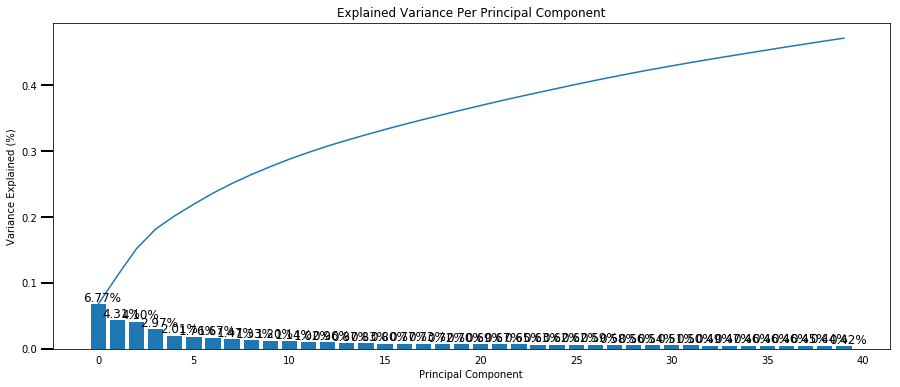

In [41]:
ipca, idf_pca = do_pca(40, adf_scaled)
scree_plot(ipca)

In [55]:
print(pca_features_weights(ipca, 0, adf_dummy)[:10])
print(pca_features_weights(ipca, 0, adf_dummy)[-10:])

MOBI_REGIO           0.145157
PLZ8_ANTG1           0.140843
KBA13_ANTG1          0.140170
KBA05_ANTG1          0.134542
MOBI_RASTER          0.131397
KBA05_AUTOQUOT       0.129465
KBA05_GBZ            0.127591
KBA13_AUTOQUOTE      0.126459
FINANZ_MINIMALIST    0.116610
GEMEINDETYP          0.108998
Name: 0, dtype: float64
EWDICHTE             -0.113903
ORTSGR_KLS9          -0.114130
HH_EINKOMMEN_SCORE   -0.128408
LP_STATUS_GROB_1.0   -0.128747
CAMEO_INTL_2015_W    -0.129935
PLZ8_ANTG4           -0.134211
KBA13_BAUMAX         -0.134767
KBA13_ANTG4          -0.135486
KBA13_ANTG3          -0.138638
PLZ8_ANTG3           -0.139468
Name: 0, dtype: float64


In [56]:
print(pca_features_weights(ipca, 1, adf_dummy)[:10])
print(pca_features_weights(ipca, 1, adf_dummy)[-10:])

KBA13_HERST_BMW_BENZ           0.181212
KBA13_SEG_OBEREMITTELKLASSE    0.155423
KBA13_MERCEDES                 0.154967
KBA13_BMW                      0.151157
KBA13_SITZE_4                  0.146317
KBA13_SEG_SPORTWAGEN           0.140337
KBA05_HERST1                   0.129387
KBA13_KMH_211                  0.124960
KBA13_KMH_250                  0.122711
KBA13_KW_121                   0.122297
Name: 1, dtype: float64
KBA13_HERST_ASIEN         -0.103407
KBA13_KW_0_60             -0.103950
OST_WEST_KZ               -0.107333
KBA13_HALTER_20           -0.111077
KBA13_SEG_KOMPAKTKLASSE   -0.114107
KBA13_KMH_180             -0.115783
KBA13_HALTER_25           -0.120263
KBA13_KMH_140_210         -0.128560
KBA13_SEG_KLEINWAGEN      -0.128930
KBA13_SITZE_5             -0.150497
Name: 1, dtype: float64


In [50]:
labels, model = fit_kmeans(idf_pca, 10)

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights_get_features(comp, pca, df_imputed):
    feature = df_imputed.columns[np.abs(pca.components_[comp]).argmax()]
    values = sorted(pca.components_[comp])
    return feature, values

def pca_features_weights(pca, comp, df_imputed):
    df_weights = pd.DataFrame(pca.components_, columns=list(df_imputed.columns))
    feature_values = df_weights.iloc[comp].sort_values(ascending=False)
    return feature_values


In [49]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def fit_kmeans(data, centers):
    '''
    INPUT:
        data = the dataset you would like to fit kmeans to (dataframe)
        centers = the number of centroids (int)
    OUTPUT:
        labels - the labels for each datapoint to which group it belongs (nparray)
    
    '''
    kmeans = KMeans(centers)
    model = kmeans.fit(data)
    labels = model.predict(data)
    return labels, model

In [51]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

### Part 1.1: Customers Data Analysis  
 - Load and Clean Customers data  
 - Apply PCA and Kmeans  
 - Compare with Genaral population

In [165]:
#df_cust.drop(columns=['D19_LETZTER_KAUF_BRANCHE'], inplace=True)
df_cust.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,...,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_D,PRAEGENDE_JUGENDJAHRE_M,CAMEO_INTL_2015_W,CAMEO_INTL_2015_L,NEIGHBOUR_RURAL,PLZ8_BAUMAX_Family,PLZ8_BAUMAX_Business,EINGEFUEGT_AM_New
0,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,2.0,...,1,4.0,1.0,0,1,3,1.0,1.0,0.0,1992.0
2,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,...,2,4.0,1.0,0,3,4,0.0,3.0,0.0,1992.0
3,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,NaN,0.0,...,1,4.0,0.0,1,2,4,1.0,1.0,0.0,1992.0
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,4.0,...,1,3.0,3.0,1,4,1,0.0,2.0,0.0,1992.0
5,1.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,2.0,...,1,3.0,1.0,0,3,4,0.0,1.0,0.0,1992.0


In [57]:
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})
#customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

customers_copy = customers.copy(deep=True)

#customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
df_cust, for_dummies_c = clean_data(customers_copy, feat_info_pickle, feat_info)

Before replacement:
sum is: 13864522 percenatge is: 19.765620839
After replacement:
sum is: 19286387 percenatge is: 27.4951716904
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 301, 326, 349] 43
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', '

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


OST_WEST_KZ fixed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRAEGENDE_JUGENDJAHRE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CAMEO_INTL_2015 can be deleted
WOHNLAGE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PLZ8_BAUMAX can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


EINGEFUEGT_AM is fixed
For get_dummies:     ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'] 9
To delete:           ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'] 4
Columns to delete:  ['VERDICHTUNGSRAUM', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


KBA05_BAUMAX already deleted in the previous steps
CAMEO_DEU_2015 already deleted in the previous steps


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


D19_LETZTER_KAUF_BRANCHE object


In [58]:
cust_df_dummy = make_dummies(df_cust, for_dummies_c)

Performing get_dummies on the following: ['AKT_DAT_KL', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
***get_dummies finished!


In [59]:
cscaler, cdf_scaled = do_scaling(cust_df_dummy)

Scaling finished!


In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.

cpca, cdf_pca = do_pca(40, cdf_scaled)
#scree_plot(apca)

In [ ]:
# import pickle
# from sklearn.externals import joblib

# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))
# pca_filename = "data/pca.save"
# joblib.dump(pca, pca_filename)

in progress
in progress
in progress
in progress
in progress


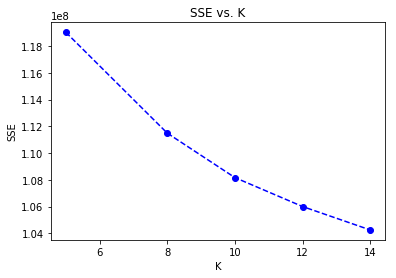

In [112]:
# Over a number of different cluster counts...

centers = [5, 8, 10, 12, 14]
#centers = [10, 15, 22]

scores = []

# run k-means clustering on the data and...
# compute the average within-cluster distances.


for center in centers:
    scores.append(get_kmeans_score(idf_pca, center))
    print('in progress')

    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [54]:
labels, model = fit_kmeans(adf_pca, 10)

In [61]:
labels_cust, model_cust = fit_kmeans(cdf_pca, 10)

Text(0.5,1,'Customers')

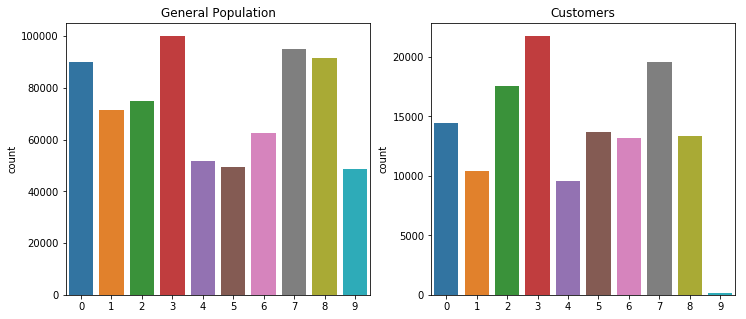

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axis = plt.subplots(figsize = (12,5), nrows=1, ncols=2)
sns.countplot(labels, ax = axis[0])
sns.countplot(labels_cust, ax = axis[1])
axis[0].set_title('General Population')
axis[1].set_title('Customers')

In [67]:
cent_scaler = StandardScaler()
cent_scaler.fit(cust_df_dummy)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_over = cent_scaler.inverse_transform(cpca.inverse_transform(model_cust.cluster_centers_[5]))

In [76]:
customers_over = pd.Series(data = centroid_over, index = cust_df_dummy.columns)
print(customers_over[:10])

LNR                           95539.195262
ALTERSKATEGORIE_FEIN              8.950343
ANZ_HAUSHALTE_AKTIV               2.970011
ANZ_PERSONEN                      1.697344
ANZ_STATISTISCHE_HAUSHALTE        2.808045
BALLRAUM                          4.430831
CJT_TYP_1                         2.048126
CJT_TYP_2                         1.550069
CJT_TYP_3                         4.648958
CJT_TYP_4                         4.705636
dtype: float64


In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_under = cent_scaler.inverse_transform(cpca.inverse_transform(model_cust.cluster_centers_[9]))
customers_under = pd.Series(data = centroid_under, index = cust_df_dummy.columns)
print(customers_under[:10])

LNR                           104213.056351
ALTERSKATEGORIE_FEIN               8.239891
ANZ_HAUSHALTE_AKTIV               -4.745089
ANZ_PERSONEN                      -0.962421
ANZ_STATISTISCHE_HAUSHALTE        -4.980280
BALLRAUM                           4.636487
CJT_TYP_1                          1.587438
CJT_TYP_2                          1.444589
CJT_TYP_3                          4.663954
CJT_TYP_4                          4.563815
dtype: float64


### Discussion: Compare Customer Data to Demographics Data

#### Overrepresented: Cluster 5
Main segments of the population which are overrepresented:

- Number of household in the buiding (ANZ_HAUSHALTE_AKTIV -> 2.97)
- Number of adults in household (ANZ_PERSONEN -> 1.69)

#### Underrepresented: Cluster 9
Main segments of the population which are underrepresented:

- Number of household in the buiding (ANZ_HAUSHALTE_AKTIV -> -4.74)
- Number of adults in household (ANZ_PERSONEN -> -0.96)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [26]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

feat_info_pickle = pd.read_pickle('data/combined_feat_info_copy.pkl')
#feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [24]:
print(mailout_test.shape, mailout_train.shape, feat_info_pickle.shape, feat_info.shape)

(42833, 366) (42962, 367) (276, 2) (85, 4)


In [21]:
def supervised_ready(df_mailout, feat_info_pickle, feat_info):
    
    df, for_dummies = clean_data(df_mailout, feat_info_pickle, feat_info)
    df_dummy = make_dummies(df, for_dummies)
        
    return df_dummy

In [27]:
mailout_clean = supervised_ready(mailout_train, feat_info_pickle, feat_info)

Before replacement:
sum is: 2217179 percenatge is: 14.0621006308
After replacement:
sum is: 3415532 percenatge is: 21.6624614846
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 349] 41
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992',

In [92]:
#mailout_clean.to_pickle('data/mailout_clean.pkl')
mailout_clean_pkl = pd.read_pickle('data/mailout_clean.pkl')

In [29]:
y_tr = mailout_clean['RESPONSE']
X_LNR = mailout_clean.drop('RESPONSE', axis=1)
X_tr = mailout_clean.drop(['RESPONSE', 'LNR'], axis = 1)
#X_train = mailout_clean.drop('LNR', axis=1)

print(y_tr.shape,X_tr.shape, X_LNR.shape)

(42962,) (42962, 429) (42962, 430)


### Stratified Kfold cross-validation  
As mentioned in the proposal, the 'RandomForestClassifier' which is the benchmark model for this project is compared with the other models under the basic configurations. The Stratified Kfold cross-validation [link](https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation) will be used for this process.

In [94]:
clfs = {'RandomForestClassifier': RandomForestClassifier(max_depth=2, random_state=0),
        'XGBRegressor': XGBRegressor(random_state=28, objective = 'binary:logistic'),
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=30), 
        'AdaBoostRegressor': AdaBoostRegressor(random_state=28)}

In [30]:
# for splitting training and testing data
skf = StratifiedKFold(n_splits=5, random_state=28, shuffle=True)
skf.get_n_splits(X_tr, y_tr)

5

In [31]:
scaler = StandardScaler()

# pipeline for scaling and model selection
def get_model(model):   
    
    pipe = Pipeline([('scale', StandardScaler()),
                     ('clf', model)])                  
    return pipe

In [33]:
# Apply machine learning pipeline
    
def get_scores(clf, X_train, y_train):    
    
    start = time()
    
    # performs scaling and 
    pipeline = get_model(clf)
    scores = []

    for train_index, test_index in skf.split(X_train, y_train):
       # print('train_index length:',len(train_index), 'test_index length', len(test_index))
        
        # data split using StratifiedKFold
        try:
            X_tr, X_tst = X_train.iloc[train_index], X_train.iloc[test_index]
            y_tr, y_tst = y_train.iloc[train_index], y_train.iloc[test_index]
            
            # training on training data
            pipeline.fit(X_tr, y_tr)

            # Predictions on test data
            y_pred = pipeline.predict(X_tst)

            # gets roc score
            score = roc_auc_score(y_tst, y_pred)
            print(score)
            scores.append(score)
            
        except:
            print('index out of bound')
        
    end = time()
    print("Finishes in {} seconds.".format(end - start))
    
    return scores

In [98]:
roc_scores = {}
for model, clf in clfs.items():
    
    roc_scores[model] = get_scores(clf, X_tr, y_tr)

RandomForestClassifier 0.5
RandomForestClassifier 0.5
RandomForestClassifier 0.5
RandomForestClassifier 0.5
RandomForestClassifier 0.5
Finishes in 5.821556806564331 seconds.
XGBRegressor 0.776404342049
XGBRegressor 0.738833503557
XGBRegressor 0.773405399543
XGBRegressor 0.703370420918
XGBRegressor 0.734898176138
Finishes in 292.11337661743164 seconds.
GradientBoostingRegressor 0.768575276349
GradientBoostingRegressor 0.768795813411
GradientBoostingRegressor 0.80737353013
GradientBoostingRegressor 0.73151058849
GradientBoostingRegressor 0.774441704393
Finishes in 213.82963228225708 seconds.
AdaBoostRegressor 0.773654859498
AdaBoostRegressor 0.758180207703
AdaBoostRegressor 0.79426874791
AdaBoostRegressor 0.733833458365
AdaBoostRegressor 0.760018766543
Finishes in 60.884737968444824 seconds.


In [99]:
roc_scores_df = pd.DataFrame(roc_scores)
roc_scores_df.columns = list(roc_scores.keys())
roc_scores_df

,RandomForestClassifier,XGBRegressor,GradientBoostingRegressor,AdaBoostRegressor
0,0.5,0.776404,0.768575,0.773655
1,0.5,0.738834,0.768796,0.758180
2,0.5,0.773405,0.807374,0.794269
3,0.5,0.703370,0.731511,0.733833
4,0.5,0.734898,0.774442,0.760019


### Benchmark model - RandomForestClassifier - GridSearchCV

In [34]:
def get_grid_best(clf, p , X, y):
    
    start = time()
    
    grid = GridSearchCV(estimator = get_model(clf),
                        param_grid = p,
                        scoring='roc_auc',
                        n_jobs=-1, iid=False, cv=5)
    grid.fit(X, y)
    
    print('best score: ',grid.best_score_, 
          'best parameter',grid.best_params_ ,
          'best estimator', grid.best_estimator_)
    
    end = time()
    print("GridSearch finished in {} seconds.".format(end - start))
    
    return grid.best_estimator_

In [91]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', RandomForestClassifier(max_depth=2, random_state=0))])

parameters = {'clf__n_estimators' : [400,600],
              'clf__max_depth'    : [5, 7, 9],
              'clf__random_state' : [0],
}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=parameters,
                    scoring='roc_auc',n_jobs=-1,
                    iid=False, cv=5)

grid.fit(X_tr, y_tr)
grid.grid_scores_, grid.best_params_, grid.best_score_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.74495, std: 0.02897, params: {'clf__max_depth': 5, 'clf__n_estimators': 400, 'clf__random_state': 0},
  mean: 0.74718, std: 0.02659, params: {'clf__max_depth': 5, 'clf__n_estimators': 600, 'clf__random_state': 0},
  mean: 0.72962, std: 0.02931, params: {'clf__max_depth': 7, 'clf__n_estimators': 400, 'clf__random_state': 0},
  mean: 0.73554, std: 0.03020, params: {'clf__max_depth': 7, 'clf__n_estimators': 600, 'clf__random_state': 0},
  mean: 0.69844, std: 0.02971, params: {'clf__max_depth': 9, 'clf__n_estimators': 400, 'clf__random_state': 0},
  mean: 0.70432, std: 0.02930, params: {'clf__max_depth': 9, 'clf__n_estimators': 600, 'clf__random_state': 0}],
 {'clf__max_depth': 5, 'clf__n_estimators': 600, 'clf__random_state': 0},
 0.74717633027053676)

### GridSearchCV - GradientBoostingRegressor  

In [46]:
max_depth = np.linspace(1, 32, 32, endpoint=True)
min_samples = np.linspace(0.1, 1.0, 10, endpoint=True)

grid_parameters = {'clf__max_depth': max_depth,
                   'clf__min_samples_split': min_samples}

clf = GradientBoostingRegressor(random_state = 28,
                               learning_rate = 0.2,
                               n_estimators = 16)

best_estimator = get_grid_best(clf, grid_parameters, X_tr, y_tr)

best score:  0.784504681096 best parameter {'clf__max_depth': 4.0, 'clf__min_samples_split': 0.5} best estimator Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=4.0,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decre...tors=16, presort='auto',
             random_state=28, subsample=1.0, verbose=0, warm_start=False))])
GridSearch finished in 14894.864715099335 seconds.


### GridSearchCV - XGBoostRegressor  
- XGBoost model with the option for binary classification : logistic regression
- Also, as there is the issue of high class imbalance therefore: scale_pos_weight = 1

In [38]:
grid_parameters = {'clf__max_depth':range(3,10,1),
                   'clf__min_child_weight':range(1,6,1)}

clf = XGBRegressor(objective = 'binary:logistic',
                   scale_pos_weight = 1,
                   random_state = 28)

best_estimator = get_grid_best(clf, grid_parameters, X_tr, y_tr)

best score:  0.762647089883 best parameter {'clf__max_depth': 3, 'clf__min_child_weight': 1} best estimator Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.3...ale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None))])
GridSearch finished in 10472.45208120346 seconds.


##### Tuning it again with the additional parameters of 'learning rate' and n_estimators. Athough, the best score came with max_depth: 3 and min_child_weight: 1 but out of curiousity changing it now as there may be an impact from the 'learning rate' and n_estimators.

In [85]:
grid_parameters = {'clf__learning_rate': [.05, .08, .12], 
                  'clf__max_depth': [5, 7],
                  'clf__min_child_weight': [4],
                  'clf__n_estimators': [100]}

clf = XGBRegressor(objective = 'binary:logistic',
                   scale_pos_weight = 1,
                   random_state = 28)

best_estimator = get_grid_best(clf, grid_parameters, X_tr, y_tr)

best score:  0.78050089319 best parameter {'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__min_child_weight': 4, 'clf__n_estimators': 100} best estimator Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.0...ale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None))])
GridSearch finished in 1856.384468793869 seconds.


##### It appears to be performing better than the previous one therefore verifying it further by increasing the n_components and reducing the learning rate. Other best parameters will be retained.

In [35]:
clf_xgb = XGBRegressor(objective = 'binary:logistic',
                   scale_pos_weight = 1,
                   random_state = 28,
                   learning_rate = .01, 
                   max_depth = 7,
                   min_child_weight = 1,
                   n_estimators = 1250)

clf_score = get_scores(clf_xgb, X_tr, y_tr)

0.746050118832
0.70261243918
0.775843898274
0.720013318273
0.740991266414
Finishes in 5150.251109361649 seconds.



##### clf_xgb is selected as the final model here as it performs better than the RandomForest and GradientBoosting algorithms. 

Text(0.5,0,'Feature Importance')

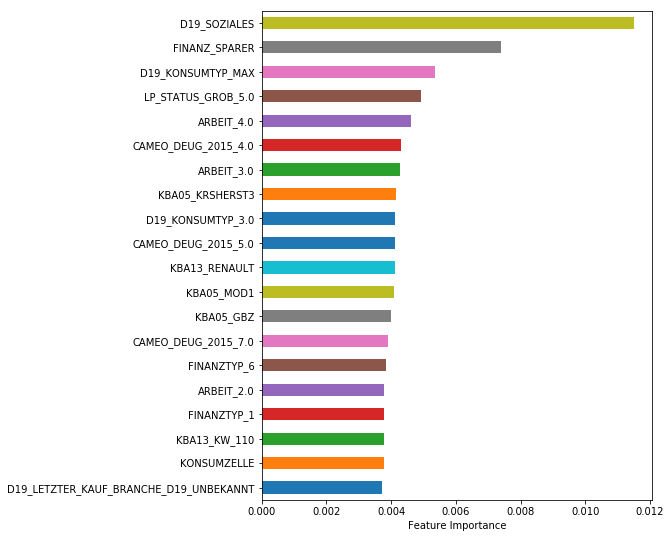

In [36]:
imp_features = clf_xgb.feature_importances_

pd.Series(imp_features, index=X_tr.columns).sort_values()[-20:].plot(kind='barh', figsize=(7,9))
plt.xlabel('Feature Importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [37]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

In [38]:
# Data cleaning
# The cleaning function can be modified - rows should not be deleted
X_test_LNR = supervised_ready(mailout_test, feat_info_pickle, feat_info)

Before replacement:
sum is: 2186757 percenatge is: 13.9489316687
After replacement:
sum is: 3379057 percenatge is: 21.5544000534
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 349] 41
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992',

In [39]:
X_test = X_test_LNR.drop('LNR', axis=1)
LNR = X_test_LNR['LNR'].tolist()

print(X_test.shape, len(LNR))

(42833, 429) 42833


In [41]:
model = get_model(clf_xgb)
model.fit(X_tr, y_tr)
results = model.predict(X_test)

In [42]:
results = pd.DataFrame({'RESPONSE':results})
results['LNR'] = LNR
result = results[['LNR', 'RESPONSE']]
print(result.head())

    LNR  RESPONSE
0  1754  0.022407
1  1770  0.016826
2  1465  0.001442
3  1470  0.001189
4  1478  0.001695


In [137]:
# previous result
#results.head()

,RESPONSE,LNR
0,0.032386,1754
1,0.032386,1770
2,0.002609,1465
3,0.002609,1470
4,0.002609,1478


In [43]:
results = results.set_index('LNR')
results.head()

,RESPONSE
LNR,
1754,0.022407
1770,0.016826
1465,0.001442
1470,0.001189
1478,0.001695


In [44]:
results.to_csv('submit.csv')

In [45]:
results.shape

(42833, 1)

### Kaggle score: 0.76141